In [103]:
import numpy as np
from skimage.measure import block_reduce
import matplotlib.pyplot as plt
from scipy import optimize
from pandas import DataFrame
import math
import scipy.optimize as opt

%matplotlib inline

In [104]:
data = np.loadtxt('./data/Lastscan.csv',delimiter=",")   
angles = []
angle_step = 10
for i in range(len(data)):
    angles.append(i*angle_step)
print(angles)
len(angles)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180]


19

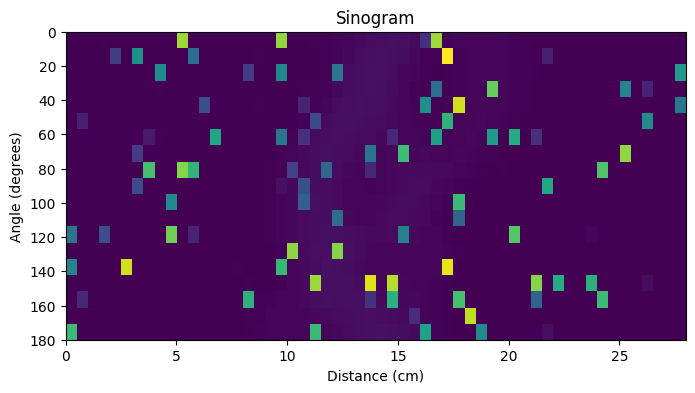

In [105]:
fig,ax = plt.subplots(figsize = (8,4))
start_dist = 0
end_dist = 28
start_angle = 0
end_angle = angles[-1]  # This is the last angle in the array, no matter how many angles are in it.
ax.imshow(data,extent=[start_dist,end_dist,end_angle,start_angle],aspect="auto")
ax.set_xlabel("Distance (cm)")
ax.set_ylabel("Angle (degrees)")
ax.set_title("Sinogram");

Since we see numerous erronius data cells, we want to completely eliminate them rather than average average them into the surrounding data.

In [106]:
def smear(array,x,y):
    adjacent = []
    xsequence = [-1,-1,-1,0,0,1,1,1]
    ysequence = [-1,0,1,-1,1,-1,0,1]
    for index,item in enumerate(xsequence):
        try:
            adjacent.append(array[x+xsequence[index]][y+ysequence[index]])
        except:
            pass
    return np.median(adjacent)

cutoff_threshold = 1.5e4
data2 = np.zeros_like(data)
for i in range(len(data)):
    for j in range(len(data[0])):
        if(data[i][j]>cutoff_threshold ):
            data2[i][j] = smear(data,i,j)
        else:
            data2[i][j] = data[i][j]
data = data2

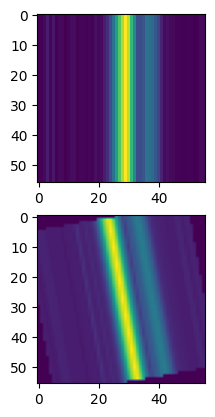

In [107]:
from scipy import ndimage
expand_vec = np.ones(data[0].size)  # this is used to get us a square matrix
expanded_data = []
for item in data:
    expanded_data.append(np.outer(expand_vec,item))

rotated_data = []
for index, item in enumerate(expanded_data):
    rotated_data.append(ndimage.rotate(item,angles[index],reshape=False,order=1)) # we want Numpy to keep our square, 2d matricies.
    
fig, (ax,ay) = plt.subplots(2)
ax.imshow(rotated_data[0])
ay.imshow(rotated_data[1])


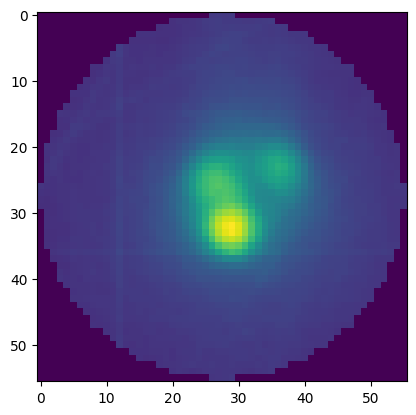

In [108]:
composite = np.ones_like(rotated_data[0])
for item in rotated_data:
    composite *= item
normalized = np.power(composite,(1/len(rotated_data))) #

fig, ax = plt.subplots()
ax.imshow(normalized)

In [109]:
def n_avg(list, i, j):
    sum = 0
    div = 0
    for offset_i in [-1,0, 1]:
        for offset_j in [-1,0, 1]:
            new_i = i + offset_i
            new_j = j + offset_j
            if (new_i >= 0 and new_j >= 0 and new_i < len(list) and new_j < len(list)):
                sum += list[new_i][new_j]
                div += 1
    avg = (sum-list[i][j]) / (div-1)
    return avg

def smoothing(list):
    for x in range(0,len(list)):
        for y in range(0,len(list)):
            if list[x][y] > 1.25*n_avg(list,x,y):
                list[x][y] = n_avg(list,x,y)
    return(list)

def smoothingFunction(list,iterations):
    runs=0
    while runs < iterations:
        for i in range(0,len(list)):
            smoothing(list[i])
        runs += 1

In [110]:
smoothingFunction(rotated_data,50)

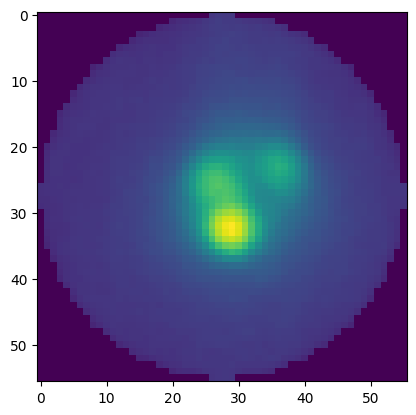

In [112]:
composite = np.ones_like(rotated_data[0])
for item in rotated_data:
    composite *= item
normalized = np.power(composite,(1/len(rotated_data))) #

fig, ax = plt.subplots()
ax.imshow(normalized)

[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [3].
[findpeaks] >Detect peaks using topology method with limit at None.
[findpeaks] >Detect peaks using topology method with limit at None.
[findpeaks] >Fin.


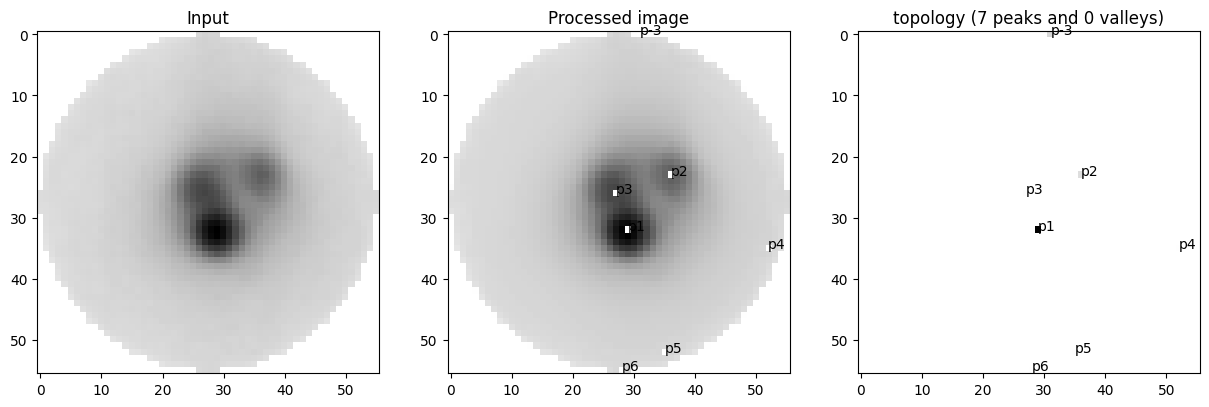

(<AxesSubplot:title={'center':'Input'}>,
 <AxesSubplot:title={'center':'Processed image'}>,
 <AxesSubplot:title={'center':'topology (7 peaks and 0 valleys)'}>)

In [114]:
from findpeaks import findpeaks

fp = findpeaks(method='topology')
results = fp.fit(normalized)
fp.plot()

In [115]:
results['persistence'].head()

,x,y,birth_level,death_level,score,peak,valley
0,29,32,255.0,0.0,255.0,True,False
1,36,23,160.0,127.0,33.0,True,False
2,27,26,186.0,183.0,3.0,True,False
3,52,35,44.0,43.0,1.0,True,False
4,35,52,43.0,42.0,1.0,True,False


In [196]:
def data_fit(p0, func, xvar, yvar, err, tmi=0):
    try:
        fit = optimize.least_squares(residual, p0, args=(func,xvar, yvar, err), verbose=tmi)
    except Exception as error:
        print("Something has gone wrong:",error)
        return p0, np.zeros_like(p0), -1, -1
    pf = fit['x']

    print()

    try:
        cov = np.linalg.inv(fit['jac'].T.dot(fit['jac']))          
        # This computes a covariance matrix by finding the inverse of the Jacobian times its transpose
        # We need this to find the uncertainty in our fit parameters
    except:
        # If the fit failed, print the reason
        print('Fit did not converge')
        print('Result is likely a local minimum')
        print('Try changing initial values')
        print('Status code:', fit['status'])
        print(fit['message'])
        return pf, np.zeros_like(pf), -1, -1
            #You'll be able to plot with this, but it will not be a good fit.

    chisq = sum(residual(pf, func, xvar, yvar, err) **2)
    dof = len(xvar) - len(pf)
    red_chisq = chisq/dof
    pferr = np.sqrt(np.diagonal(cov)) # finds the uncertainty in fit parameters by squaring diagonal elements of the covariance matrix
    pfcov = cov[0,1]
    print('Converged with chi-squared {:.2f}'.format(chisq))
    print('Number of degrees of freedom, dof = {:.2f}'.format(dof))
    print('Reduced chi-squared {:.2f}'.format(red_chisq))
    print()
    Columns = ["Parameter #","Initial guess values:", "Best fit values:", "Uncertainties in the best fit values:"]
    print('{:<11}'.format(Columns[0]),'|','{:<24}'.format(Columns[1]),"|",'{:<24}'.format(Columns[2]),"|",'{:<24}'.format(Columns[3]))
    for num in range(len(pf)):
        print('{:<11}'.format(num),'|','{:<24.3e}'.format(p0[num]),'|','{:<24.3e}'.format(pf[num]),'|','{:<24.3e}'.format(pferr[num]))
    return pf, pferr, chisq, dof

def residual(p,func, xvar, yvar, err):
    return (func(p, xvar) - yvar)/err

def gaussianfunc_bg(p,x):
    return p[0]/(p[2]*np.sqrt(2*np.pi))*np.exp(-(x-p[1])**2/(2*p[2]**2))+p[3]


def featureIdentification(norm_array,x,x_coord,y_coord,x_bound,y_bound):
    yx=norm_array[y_coord]
    dyx=np.sqrt(yx)
    x_guess=np.array([4*yx[x_coord],x_coord/2,2,0.1*yx[x_coord]])

    yy=norm_array[:,x_coord]
    dyy=np.sqrt(yy)
    y_guess=np.array([4*yy[y_coord],y_coord/2,2,0.1*yy[y_coord]])

    xmin_value,xmax_value=x_coord-x_bound[0], x_coord+x_bound[1]
    ymin_value,ymax_value=y_coord-y_bound[0], y_coord+y_bound[1]

    x_pf, x_pferr, x_chisq, x_dof = data_fit(x_guess, gaussianfunc_bg, x[xmin_value:xmax_value], yx[xmin_value:xmax_value], dyx[xmin_value:xmax_value])
    y_pf, y_pferr, y_chisq, y_dof = data_fit(y_guess, gaussianfunc_bg, x[ymin_value:ymax_value], yy[ymin_value:ymax_value], dyy[ymin_value:ymax_value])

    print(' ')
    print(ymin_value,ymax_value)
    print('===============================================')
    print('Feature identified at ({:.2f} +- {:.2f},{:.2f} +- {:.2f}) cm'.format(x_pf[1],x_pferr[1],y_pf[1],y_pferr[1]) )

In [197]:
x = []
step = 0.5
while step <= 28:
    x.append(step)
    step += 0.5

x = np.array(x)
x

array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ,
       11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5,
       17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. ,
       22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. , 27.5,
       28. ])

In [198]:
xcoord = results['persistence'].iloc[0]['x']
ycoord = results['persistence'].iloc[0]['y']
print(xcoord,ycoord)
featureIdentification(normalized,x,xcoord,ycoord,(8,8),(4,4))

29 32

Converged with chi-squared 40.01
Number of degrees of freedom, dof = 12.00
Reduced chi-squared 3.33

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 4.378e+04                | 3.103e+04                | 6.439e+02               
1           | 1.450e+01                | 1.492e+01                | 1.072e-02               
2           | 2.000e+00                | 1.637e+00                | 2.354e-02               
3           | 1.094e+03                | 3.359e+03                | 7.412e+01               

Converged with chi-squared 8.88
Number of degrees of freedom, dof = 4.00
Reduced chi-squared 2.22

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 4.378e+04                | 9.405e+03                | 1.057e+03               
1           | 1.600e+01                | 1.659e+01                | 2.191e-02               
2           | 2.000e+0

In [199]:
xcoord = results['persistence'].iloc[1]['x']
ycoord = results['persistence'].iloc[1]['y']
print(xcoord,ycoord)
featureIdentification(normalized,x,xcoord,ycoord,(2,6),(5,5))

36 23

Converged with chi-squared 2.34
Number of degrees of freedom, dof = 4.00
Reduced chi-squared 0.58

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 2.758e+04                | 2.453e+04                | 4.954e+03               
1           | 1.800e+01                | 1.851e+01                | 3.068e-02               
2           | 2.000e+00                | 1.800e+00                | 1.685e-01               
3           | 6.895e+02                | 1.440e+03                | 6.249e+02               

Converged with chi-squared 13.64
Number of degrees of freedom, dof = 6.00
Reduced chi-squared 2.27

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 2.758e+04                | 2.679e+04                | 6.032e+03               
1           | 1.150e+01                | 1.225e+01                | 2.424e-02               
2           | 2.000e+00

In [200]:
xcoord = results['persistence'].iloc[2]['x']
ycoord = results['persistence'].iloc[2]['y']
print(xcoord,ycoord)
featureIdentification(normalized,x,xcoord,ycoord,(5,7),(6,2))

27 26

Converged with chi-squared 79.07
Number of degrees of freedom, dof = 8.00
Reduced chi-squared 9.88

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 3.199e+04                | 2.010e+04                | 3.022e+03               
1           | 1.350e+01                | 1.415e+01                | 1.967e-02               
2           | 2.000e+00                | 1.824e+00                | 1.321e-01               
3           | 7.997e+02                | 3.631e+03                | 3.724e+02               

Converged with chi-squared 1.46
Number of degrees of freedom, dof = 4.00
Reduced chi-squared 0.37

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 3.199e+04                | 2.383e+04                | 5.731e+03               
1           | 1.300e+01                | 1.336e+01                | 6.840e-02               
2           | 2.000e+00